# Use case 2: seismic monitoring design based on sensitivity analysis of Kimberlina 2.0 models

### Objective
Deploy seismic sources and receivers to locations that are most sensitive to target monitoring regions and collect as fewer data as possible to achieve imaging resolution comparable to that of a full seismic survey.

## Table of Contents: <a class="anchor" id="bullet0"></a>
* [1. Defines site settings, objectives and criteria.](#bullet1)
* [2. Input parameters of the spatial and temporal data.](#bullet2)
* [3. Load 2D baseline seismic velocity models.](#bullet3)
* [4. Load plume models that define target monitoring region(s).](#bullet4)
* [5. Load and visualize seismic sensitivity data.](#bullet5)
* [6. Find and visualize optimal seismic arrays interactively.](#bullet6)
* [7. Design and visualize adaptive seismic monitoring.](#bullet7)


### 1. Defines site settings, objectives and criteria <a class="anchor" id="bullet1"></a>

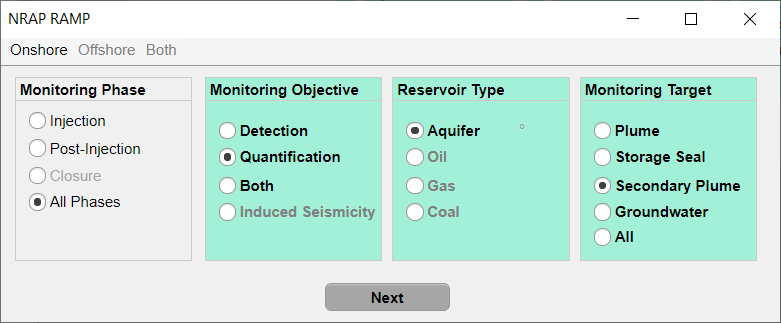

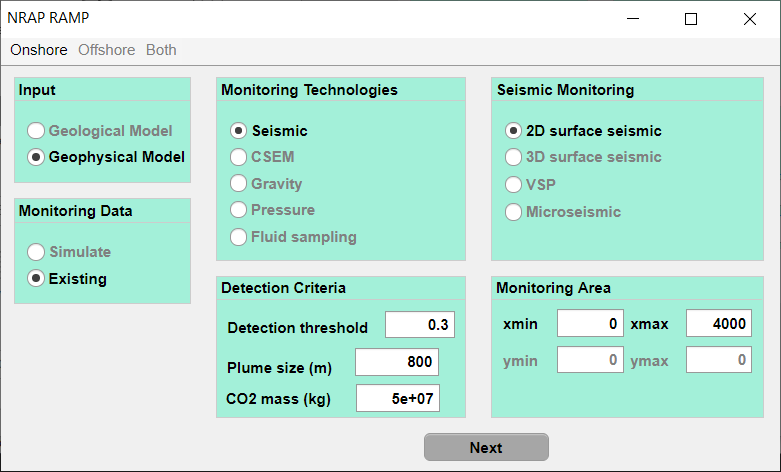

### Import required Python modules

In [1]:
# Import required Python packages
import os, sys, glob, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
from matplotlib.colors import LinearSegmentedColormap
mpl.rcParams.update({'font.size': 16})

### 2. Input parameters of the spatial and temporal data <a class="anchor" id="bullet2"></a>
Back to [TOC](#bullet0).

In [2]:
# 2D seismic velocity, density and CO2 plume mask models
nx = 1467; nz = 335
dx = dz = 7.5

# time points of temporal data
t1 = 78        # the year when fault leakage breaks thru 2nd formation
timestamps = np.array([80, 85, 90, 95, 100, 125])
time_points = [str(s) for s in timestamps-t1]
timestamps = [str(s) for s in timestamps]
num_time_points = len(time_points)

# 2D seismic sensitivity data
num_sources = 146
num_receivers = 1467
source_interval = 75.0      # source interval (m)
receiver_interval = 7.5     # Receiver interval (m)
units = {'vp': '(m/s)', 'vs': '(m/s)', 'density': '(kg/m$^3$)'}
wavefield = ['P', 'S']
VpVs = ['Vp', 'Vs']

# Optimal seismic survey design
# Sensitivity thresholds in fraction between (0, 1). The first threshold is 
# for plume imaging and the 2nd one is for detection of plume
sensitivity_threshold = [0.2, 0.6]
scale_src_interval = 4
scale_rec_interval = 4


### 3. Load and visualize 2D baseline seismic velocity models <a class="anchor" id="bullet3"></a>
Back to [TOC](#bullet0).

In [3]:
%matplotlib inline

In [4]:
# Setup directories
data_dir = 'C:/Users/yang25/OneDrive - LLNL/NRAP/FY23/sensitivity_kim2/'
out_dir = data_dir + 'notebook/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
model_dir = data_dir + 'models_plume_mask/'


In [5]:
def create_cmap():
    ''' Create a custom linear colormap

    Returns
    -------
    cmap: LinearSegmentedColormap
    '''
    colors = [(0.00, '#ffffff'),
              # (0.03, '#ffff00'),
              (1.00, '#ff0000')]
    cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=64)
    return cmap

In [6]:
def read_seismic_model(fname):
    '''
    Read a 2D binary seismic model file, e.g., Vp, Vs, density
    A binary seismic model data is saved in single precision floats (4B)
    and little endian. The number of floats = nz x nx. Data are located
    on an equally-spaced rectangular grid of nz rows and nx columns.
    The binary data are saved in a column-major order in a shape (nx,nz)

    Parameters
    ----------
    fname: str
        Seismic model file name with path

    Returns
    -------
    data : ndarray (dtype=float, ndim=2)
        seismic (Vp, Vs or density) model in a 2D numpy array
    '''

    data = np.fromfile(fname, dtype=np.float32, count=-1, sep='')
    data = data.reshape(nx, nz)  # column major array
    return data


In [7]:
def plot_model_image(fname):
    ''' Plot baseline Vp, Vs or density model or CO2 plume mask model
    Parameters
    ----------
    fname: str
        baseline Vp, Vs, density model or plume mask file name

    '''
    cmap = create_cmap()
    model = read_seismic_model(fname)
    sDir, basename = os.path.split(fname)
    tokens = basename.split('.')
    param = tokens[0].split('_')[0]  # vp, vs, den, mask
    if param.lower() == 'den': return
        
    fig, ax = plt.subplots(figsize=(10, 5))

    if param.lower() == 'mask':  # mask
        img = ax.imshow(model.T, extent=[0, nx * dx, nz * dz, 0], cmap=cmap)
        s = tokens[0][:-8]
        ss = s[-3:]
        if ss[0] == 'y': ss = ss[1:]
        yr = str(int(ss) - t1)
        annotate = 'CO$_2$ plume mask at t1+' + yr + ' years'
        label = 'CO$_2$ Plume Mask'
        ax.text(200, 400, annotate, color='black')
    else:
        img = ax.imshow(model.T, extent=[0, nx * dx, nz * dz, 0], cmap='jet')
        if len(param)==3: param='density'
        annotate = param.title()
        label = annotate + units[param]
        fig.colorbar(img, label=label, orientation='horizontal',
                 fraction=0.06, shrink=0.5, pad=0.18, aspect=30)
        ax.text(200, 400, annotate, color='white')

    ax.set_xlabel('Horizontal Distance (m)')
    ax.set_ylabel('Depth (m)')
    ax.grid(lw=0.2, alpha=0.5)
    plt.tight_layout()



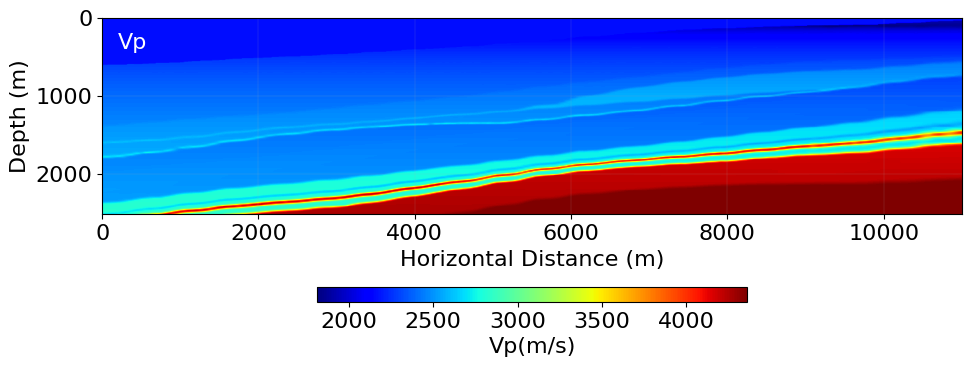

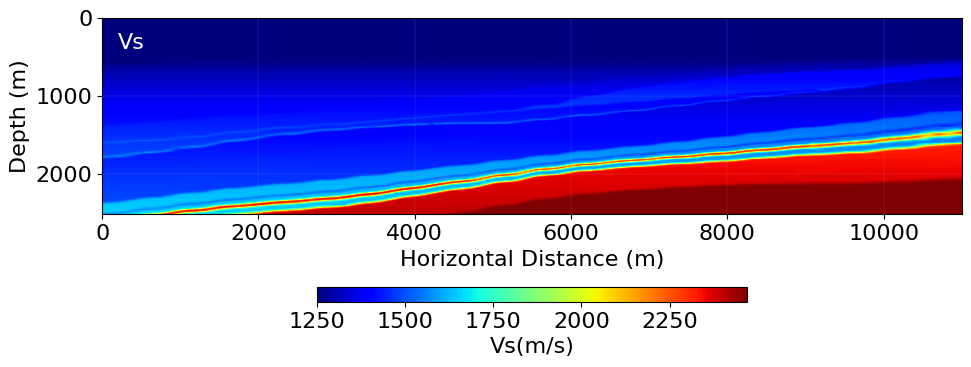

In [8]:
fnames = glob.glob(model_dir + '*.bin')
fnames.sort()
fnames = np.array(fnames)
# Total 10 bin model files. Plot baseline velocity model first, 
# then plume model in chronological order in the following cell
idx = [8, 9]
fnames = fnames[idx]

for fname in fnames:
    plot_model_image(fname)


### 4. Load and visualize plume models that define target monitoring region(s) <a class="anchor" id="bullet4"></a>
Back to [TOC](#bullet0).

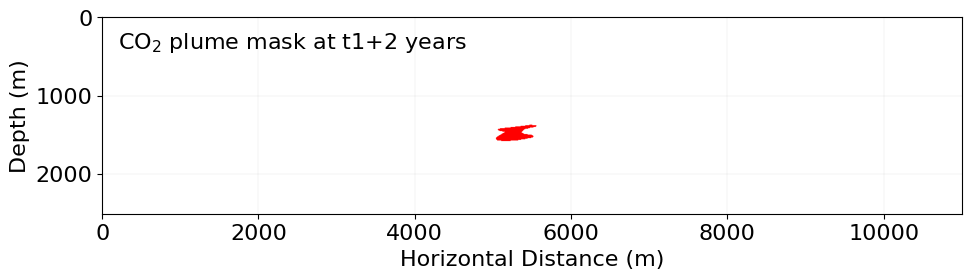

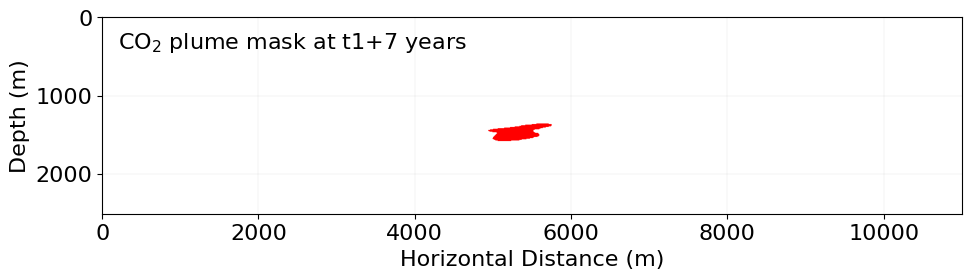

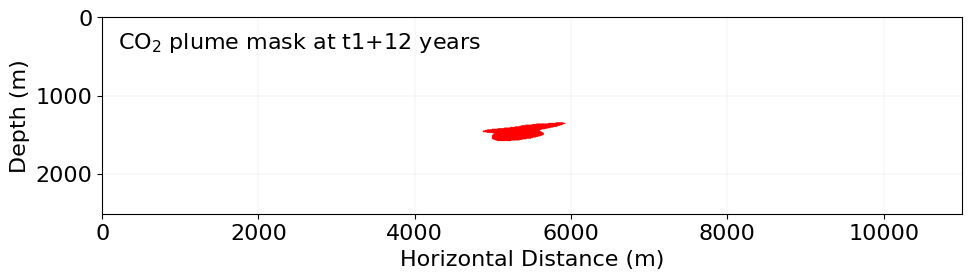

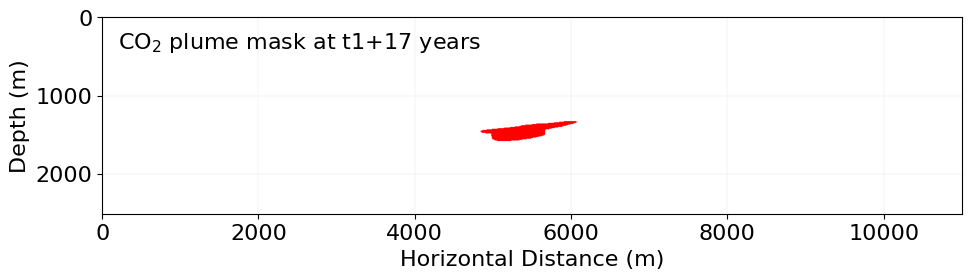

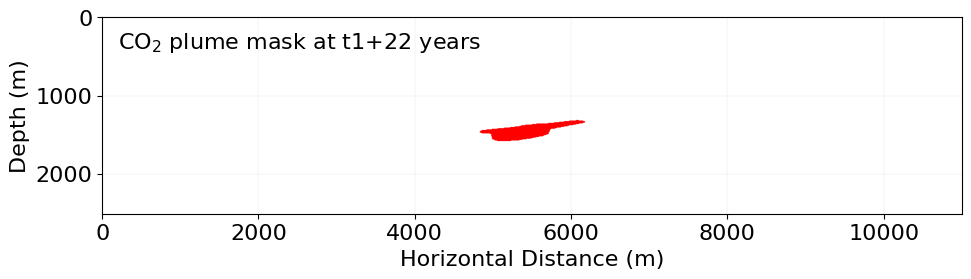

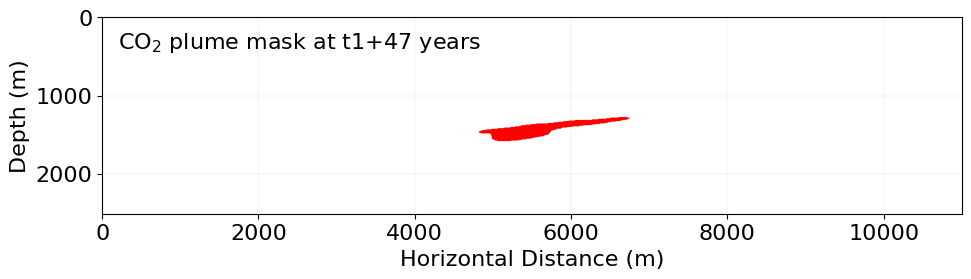

In [9]:
fnames = glob.glob(model_dir + '*.bin')
fnames.sort()
fnames = np.array(fnames)
# Total 10 bin model files. plot plume model in chronological order
idx = [4, 5, 6, 7, 1, 2]
fnames = fnames[idx]

for fname in fnames:
    plot_model_image(fname)

### 5. Load and visualize seismic sensitivity data <a class="anchor" id="bullet5"></a>
Back to [TOC](#bullet0).

In [10]:
def load_sensitivity_data(yr, wf, vpvs):
    ''' Load sensitivity data of all sources per senstivity component (wf, vpvs)
    and per time step (yr). Scale sensitivity data between 0 and 1

    Parameters
    ----------
    yr: str
        a time step in years, e.g., '80'
    wf: str
        P or S waveform (data)
    vpvs: str
        sensitivity wrt Vp or Vs (model)

    Returns
    -------
    sens: ndarray(dtype=float, ndim=2)
        an array of sensitivity data in a shape (num_sources, num_receivers)

    '''

    sDir = data_dir + f'EW_sensitivity_results_ol_y{yr}_leakage/'
    sens = np.zeros((num_sources, num_receivers))
    for i in range(1, num_sources+1):
        fname = f'receiver_sensitivity_{wf}_wrt_{vpvs}_src_{i:d}.bin'
        sens[i-1,:] = np.fromfile(sDir+fname, dtype=np.float32, count=-1, sep='')

    maxSens = np.max(sens)
    minSens = np.min(sens)
    dsens = maxSens - minSens
    sens = (sens - minSens) / dsens
    return sens

In [11]:
def find_optimal_seismic_arrays(sens,threshold):
    '''
    Find optimal sources and receivers with scaled sensitivity
    above a threshold and scale source and reciver interval

    Parameters
    ----------
    sens2d: ndarray(dtype=float, ndim=2)
        an array of sensitivity data in a shape (nSources, nReceivers)
    threshold: float
        Sensitivity thresholds in fraction between (0, 1)

    Returns
    -------
    out: ndarray(dtype=bool, ndim=2)
        an array of sensitivity masks showing optimal source and receiver locations

    '''
    out = sens >= threshold
    # increase source and receiver interval because simulated data are oversampled
    out = out[::scale_src_interval, ::scale_rec_interval]
    return out


In [12]:
def plot_sensitivity_images(sens, wf, vpvs, areas):
    ''' Create a sensitivity image with x=receivers, y=sources
    per senstivity component and per time step (years)

    Parameters
    ----------
    sens: ndarray(dtype=float, ndim=3)
        Sensitivity data array in a shape (num_time_points, num_sources, num_receivers)
    wf: str
        P or S waveform (data)
    vpvs: str
        sensitivity wrt Vp or Vs (model)
    areas: ndarray(dtype=float, ndim=2)
        Area (%) of sensitivity above 2 thresholds in a shape (num_time_points, 2)

    '''
    sens_comp = 'W'+wf.lower() + '/' + vpvs
    fig, ax = plt.subplots(3,2, figsize=(12, 16), sharex=True)
    x = np.linspace(0, (num_receivers-1)*receiver_interval, num_receivers)
    y = np.linspace(0, (num_sources-1)*source_interval, num_sources)
    X, Y = np.meshgrid(x, y)
    cmap = create_cmap()
    extent = [0, (num_receivers-1)*receiver_interval, (num_sources-1)*source_interval, 0]
    for iyr, yr in enumerate(timestamps):
        i = iyr // 2
        j = iyr % 2
        img = ax[i,j].imshow(sens[iyr,:,:],extent=extent,vmin=0.0,vmax=1.0,cmap=cmap)
        yrs = 't1+' + str(int(yr)-t1) + ' years'
        ax[i,j].text(200, 300, yrs, color='k')
        # ax[i,j].text(8450, 10000, sens_comp, color='k')
        ax[i,j].text(4600, 10000, '%data to collect', color='k')
        ax[i,j].text(8450, 9000, f'{areas[iyr,0]:.1f}%', color='brown')
        ax[i,j].text(8450, 8000, f'{areas[iyr,1]:.1f}%', color='m')
        ax[i,j].set_ylim(ax[i,j].get_ylim()[::-1])
        CS = ax[i,j].contour(X,Y,sens[iyr,:,:],sensitivity_threshold,vmin=0.0,vmax=1.0,
                             linestyles='solid', linewidths=[0.3, 1.3], colors=['brown', 'm'])
        ax[i,j].set_xlabel('Receiver Location (m)')
        ax[i,j].set_ylabel('Source Location (m)')
        ax[i,j].grid(color='k', lw=0.3, alpha=0.2)

    plt.subplots_adjust(bottom=0.08)
    cbar_ax = fig.add_axes([0.3, 0.01, 0.4, 0.01])
    plt.colorbar(img, cax=cbar_ax, label='Scaled Sensitivity '+sens_comp, orientation='horizontal')
    # fig.colorbar(img, label='Scaled Sensitivity ' + clabel, orientation='horizontal',
    #              fraction=0.05, shrink=0.5, pad=0.1, aspect=30)
    # plt.tight_layout()


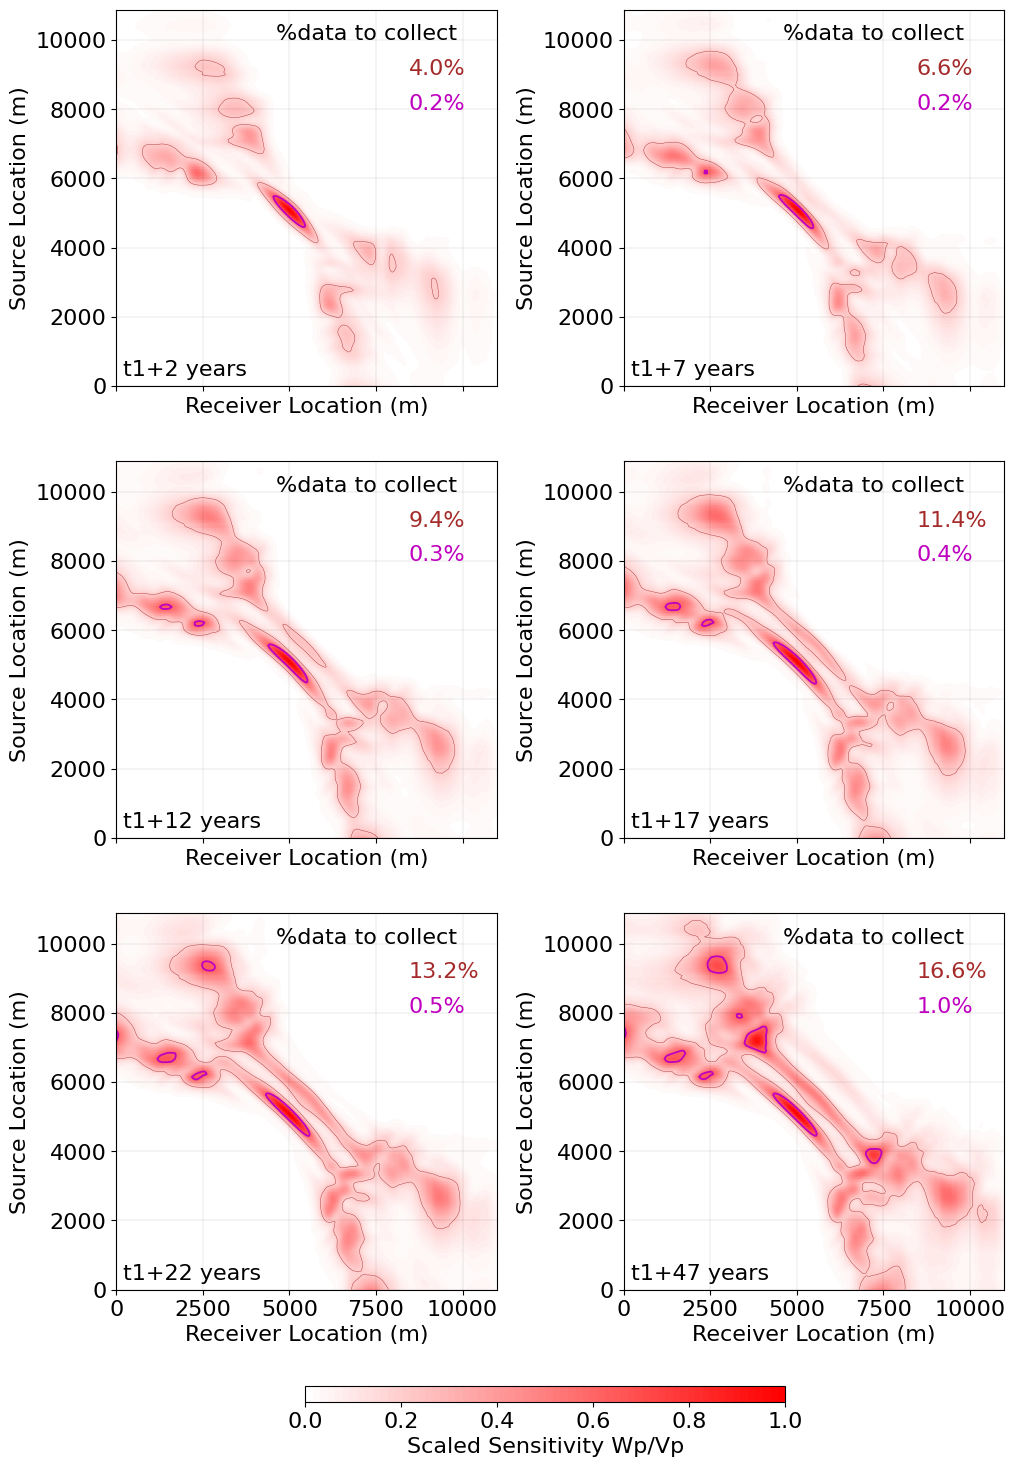

In [13]:
# plot sensitivity images
# Calculate optimal area of senitivity above two thresholds
sens_years = np.zeros((len(timestamps), num_sources, num_receivers))
k = 0
for wf in wavefield[:1]:
    for ps in VpVs[:1]:
        areas = np.zeros((len(timestamps), 2))  
        for i, yr in enumerate(timestamps):
            sens2d = load_sensitivity_data(yr, wf, ps)
            sens_years[i,:,:] = np.copy(sens2d)
            for j in range(2):
                arrays = find_optimal_seismic_arrays(sens2d, sensitivity_threshold[j])
                m, n = arrays.shape
                opt = np.sum(arrays)
                areas[i,j] = 100*opt / (m*n)

        plot_sensitivity_images(sens_years,wf,ps,areas)
        k += 1        

### 6. Find and visualize optimal seismic arrays interactively <a class="anchor" id="bullet6"></a>
Back to [TOC](#bullet0).

In [14]:
def find_optimal_sources(src_rec):
    ''' find optimal source indices

    Parameters
    ----------
    src_rec: ndarray(dtype=bool, ndim=2)
        an array of sensitivity masks showing optimal source and receiver locations

    Returns
    -------
    sources: list(int)
        Optimal source indices
    ns_max: int
        number of sources for all time steps
    '''

    ns, nr = src_rec.shape
    sources = []
    for i in range(ns):
        s = np.int32(src_rec[i,:])
        if np.sum(s) <= 0: continue
        sources.append(i)
    return len(sources), sources


### Interactive plot of optimal seismic monitoring design

In [15]:
from ipywidgets import interact, IntSlider, HBox, IntText, BoundedIntText
import ipywidgets as widgets

In [16]:
def interactive_plot_optimal_design(source_idx, time_idx):
    '''
    Plot and save optimal design with source, receivers and plume per time step
    and per sensitivity component

    Parameters
    ----------
    source_idx: int
        an index to sources0 list
        
    '''

    yr = timestamps[time_idx]
    wf = 'P'; ps = 'Vp'

    # create CO2 plume image
    plume_file = model_dir + 'mask_ol_y' + yr + '_leakage.bin'
    model = read_seismic_model(plume_file)
    fig, ax = plt.subplots(figsize=(12, 4))
    xMin = 0; xMax = nx * dx
    cmap = create_cmap()
    ax.imshow(model.T, extent=[0, nx*dx, nz*dz, 0], cmap=cmap)

    # Plot source and receivers
    sens2d = load_sensitivity_data(yr, 'P', 'Vp')
    # optimal_design and sources0 are global variables used in the function above
    optimal_design = find_optimal_seismic_arrays(sens2d,sensitivity_threshold[0])
    num_source_max, sources0 = find_optimal_sources(optimal_design)
    print('Optimal sources: ', sources0)
    if source_idx >= num_source_max: return

    s = np.int32(optimal_design[source_idx,:])
    y0 = -50
    xs = sources0[source_idx] * source_interval * scale_src_interval
    xr = np.float32(np.nonzero(s)) * receiver_interval * scale_rec_interval
    xr = xr[0]  # xr above is a 2D array

    plt.plot([xMin, xMax], [y0, y0], 'k-', lw=0.3)
    plt.plot([xs], [y0], 'r*', ms=12)
    plt.plot(xr, [y0]*len(xr), 'bo', ms=3)
    plt.xlim(-100, xMax)
    ax.text(200, y0+300, 'Sensitivity_threshold=' + str(sensitivity_threshold[0]), color='k')
    ax.set_yticks((0, 1000, 2000))
    ax.set_xlabel('Horizontal Distance (m)')
    ax.set_ylabel('Depth (m)')

    yrs = str(int(yr) - t1)
    annotate = 'CO$_2$ plume mask at t1+' + yrs + ' years'
    ax.text(200, 500, annotate, color='black')
    ax.grid(lw=0.3, alpha=0.7)
    ax.set_aspect('auto')
    plt.tight_layout()



In [17]:
# Create an interactive plot of optimal seismic monitoring design at t1+47 years
style = {'description_width': 'initial'}
source_idx_slider=IntSlider(description='Source Index [0,35]', value=10, min=0, max=35, step=1,
                                                      continuous_update=False, style=style)
time_idx_slider=IntSlider(description='Time Index [0,5]', value=5, min=0, max=len(timestamps)-1, step=1,
                                                      continuous_update=False, style=style)
ui = HBox([source_idx_slider, time_idx_slider])

out = widgets.interactive_output(interactive_plot_optimal_design, 
                                 {'source_idx': source_idx_slider, 
                                  'time_idx': time_idx_slider})
display(ui, out)


Output()

### 7. Design and visualize adaptive seismic monitoring <a class="anchor" id="bullet7"></a>
Back to [TOC](#bullet0).

In [18]:
def plot_optimal_design(design1, design2, wf, ps, yr, ns_max):
    '''
    Plot optimal design with source, receivers and plume per time step
    and per sensitivity component

    Parameters
    ----------
    design1: ndarray(dtype=bool, ndim=2)
        Sensitivity masks showing optimal source and receiver locations for 1st threshold
    design2: ndarray(dtype=bool, ndim=2)
        Sensitivity masks showing optimal source and receiver locations for 2nd threshold
    yr: str
        a time step in years, e.g., '80'
    wf: str
        P or S waveform (data)
    ps: str
        sensitivity wrt Vp or Vs (model)
    ns_max: ndarray(dtype=int, ndim=1)
        Max number of sources in optimal design for two thresholds

    Returns
    -------
    design: list[float]
        Seismic source coordinate and then receiver coordinates
    '''

    mpl.rcParams.update({'font.size': 18})
    plume_file = model_dir + 'mask_ol_y' + yr + '_leakage.bin'
    model = read_seismic_model(plume_file)
    ns, nr = design1.shape
    fig, ax = plt.subplots(figsize=(10, 8))
    xMin = 0; xMax = nx * dx
    cmap = create_cmap()
    ax.imshow(model.T, extent=[0, nx*dx, nz*dz, 0], cmap=cmap)

    design = []
    dy = 0
    for i_thresh in range(2):
        if i_thresh == 0: src_rec = np.copy(design1)
        else: src_rec = np.copy(design2)
            
        k = 0
        for i in range(ns):
            s = np.int32(src_rec[i,:])
            if np.sum(s) <= 0: continue
            y0 = -100 - k*200 + dy
            k += 1
            xs = i * source_interval * scale_src_interval
            xr = np.float32(np.nonzero(s)) * receiver_interval * scale_rec_interval
            xr = xr[0]  # xr above is a 2D array
            design.append(xs)
            design.append(list(xr))
    
            plt.plot([xMin, xMax], [y0, y0], 'k--', lw=0.3)
            plt.plot([xs], [y0], 'r*', ms=8)
            plt.plot(xr, [y0]*len(xr), 'bo', ms=3)
    
        for j in range(k, ns_max[i_thresh]):
            y0 = -100 - j*200 + dy
            plt.plot([xMin, xMax], [y0, y0], 'k--', lw=0.3)

        ax.text(200, y0, 'Sensitivity_threshold=' + str(sensitivity_threshold[i_thresh]), color='k')
        dy = y0 - 500

    ax.set_yticks((0, 1000, 2000))
    ax.set_xlabel('Horizontal Distance (m)')
    ax.set_ylabel('                Depth (m)                                         Source Index                            ')

    yrs = str(int(yr) - t1)
    annotate = 'CO$_2$ plume mask at t1+' + yrs + ' years'
    ax.text(200, 500, annotate, color='black')
    ax.grid(lw=0.3, alpha=0.7)
    ax.set_aspect('auto')
    plt.tight_layout()
    plt.savefig(out_dir + wf+'_'+ps+'_'+yr + 'y.png', bbox_inches='tight')
    return design



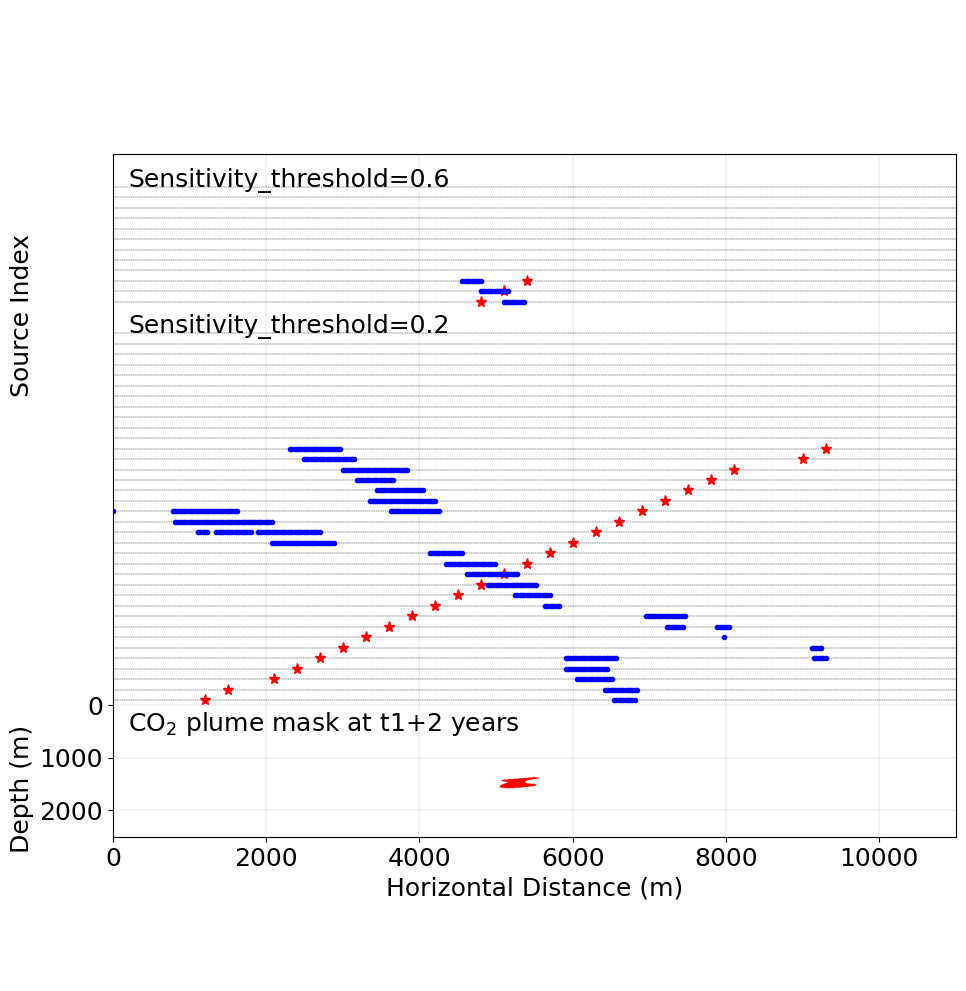

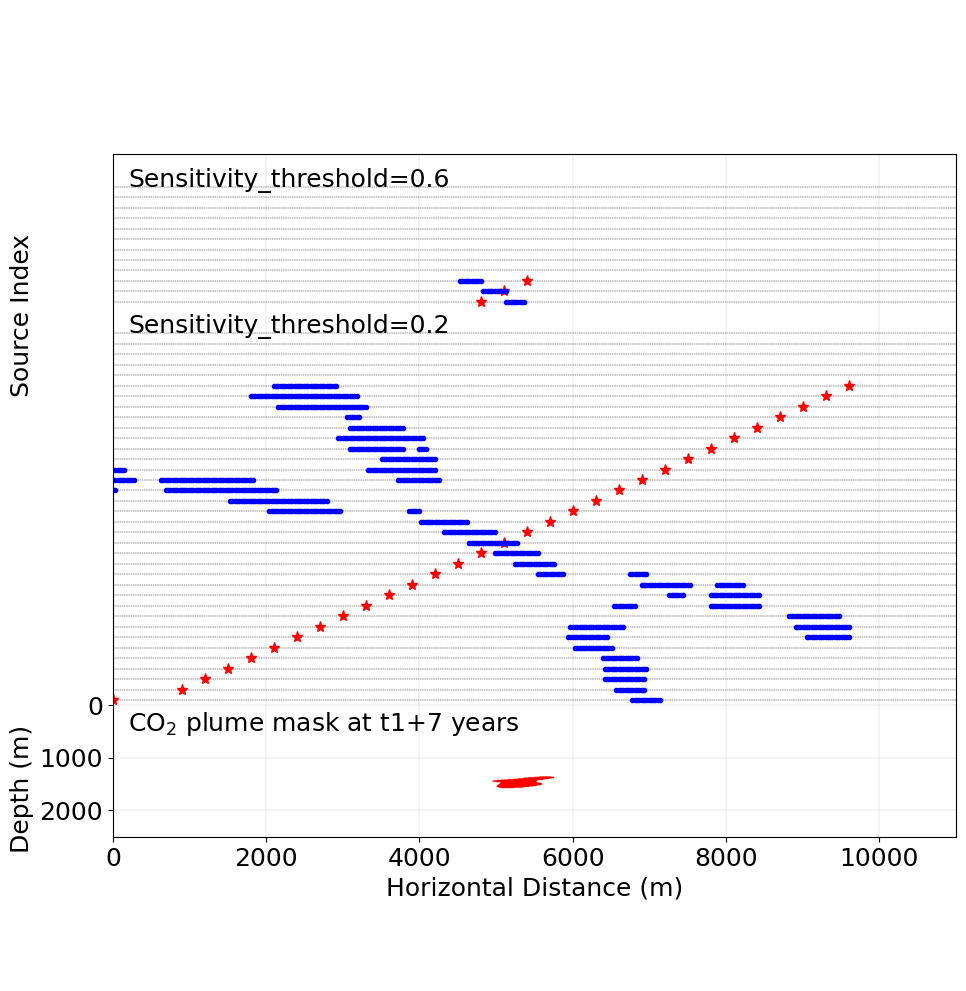

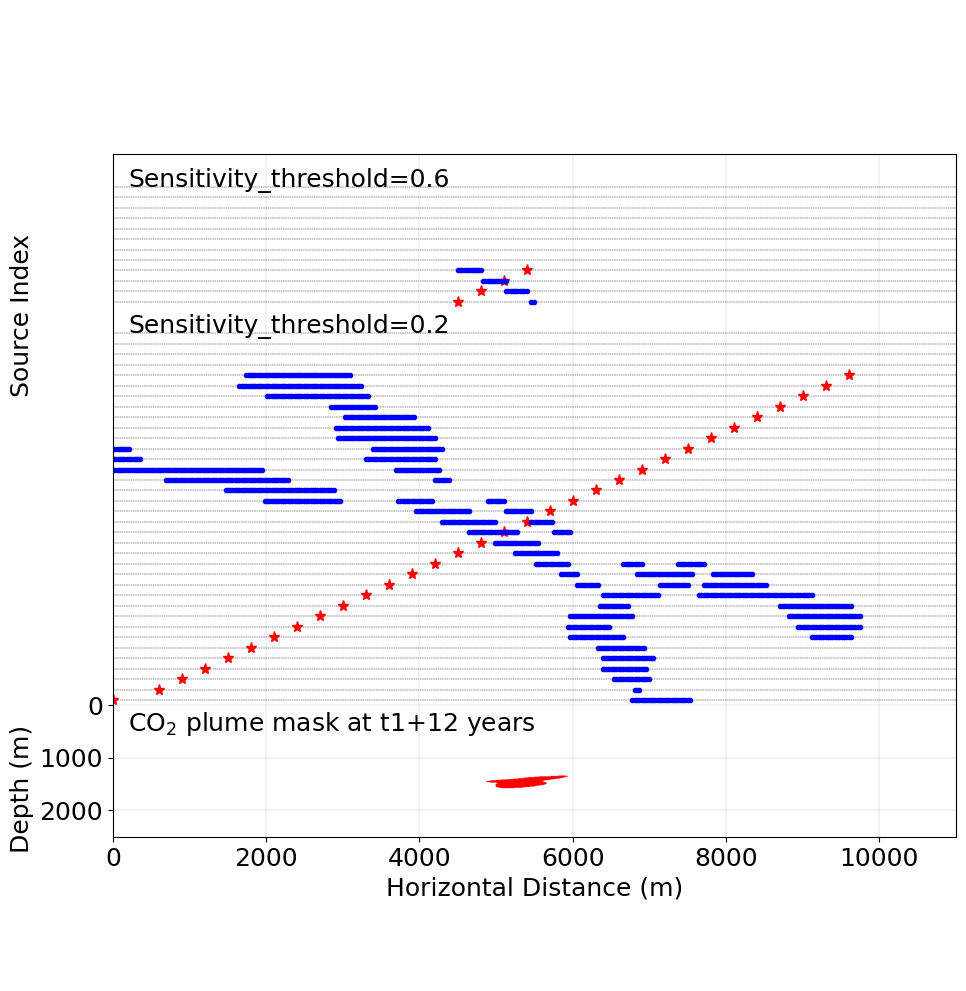

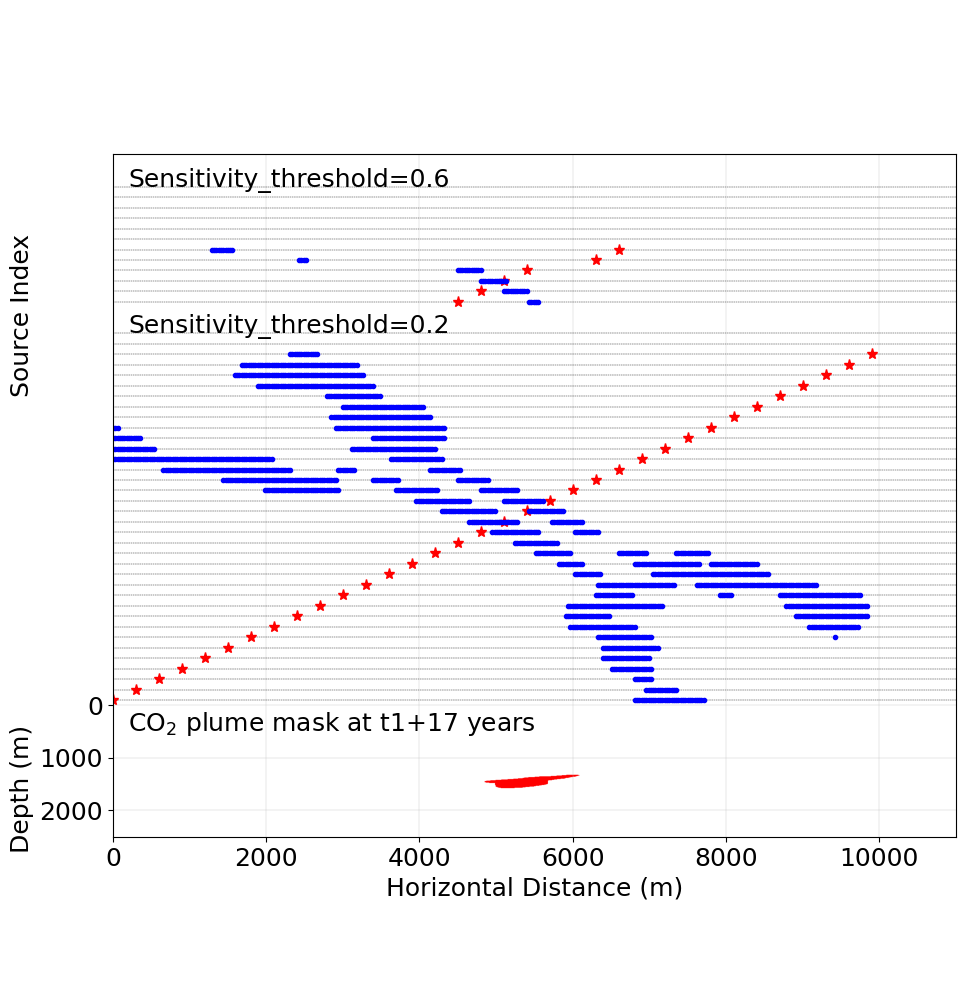

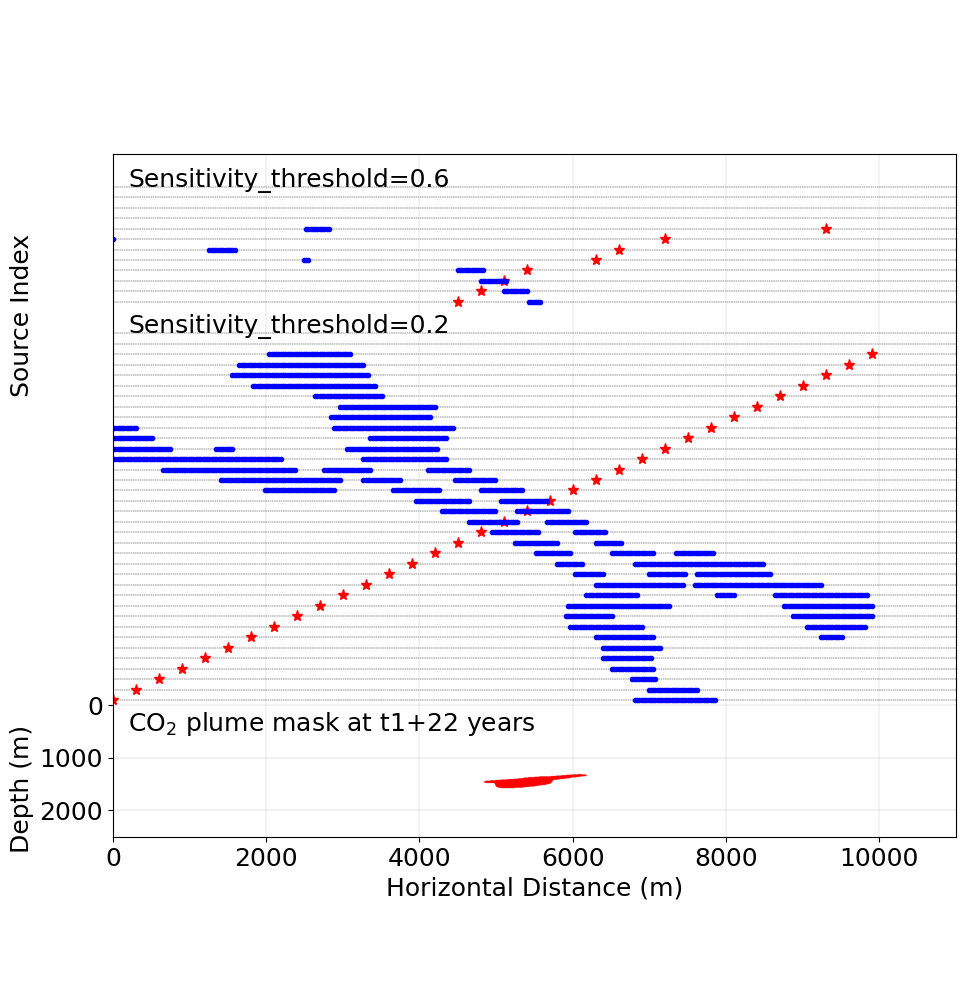

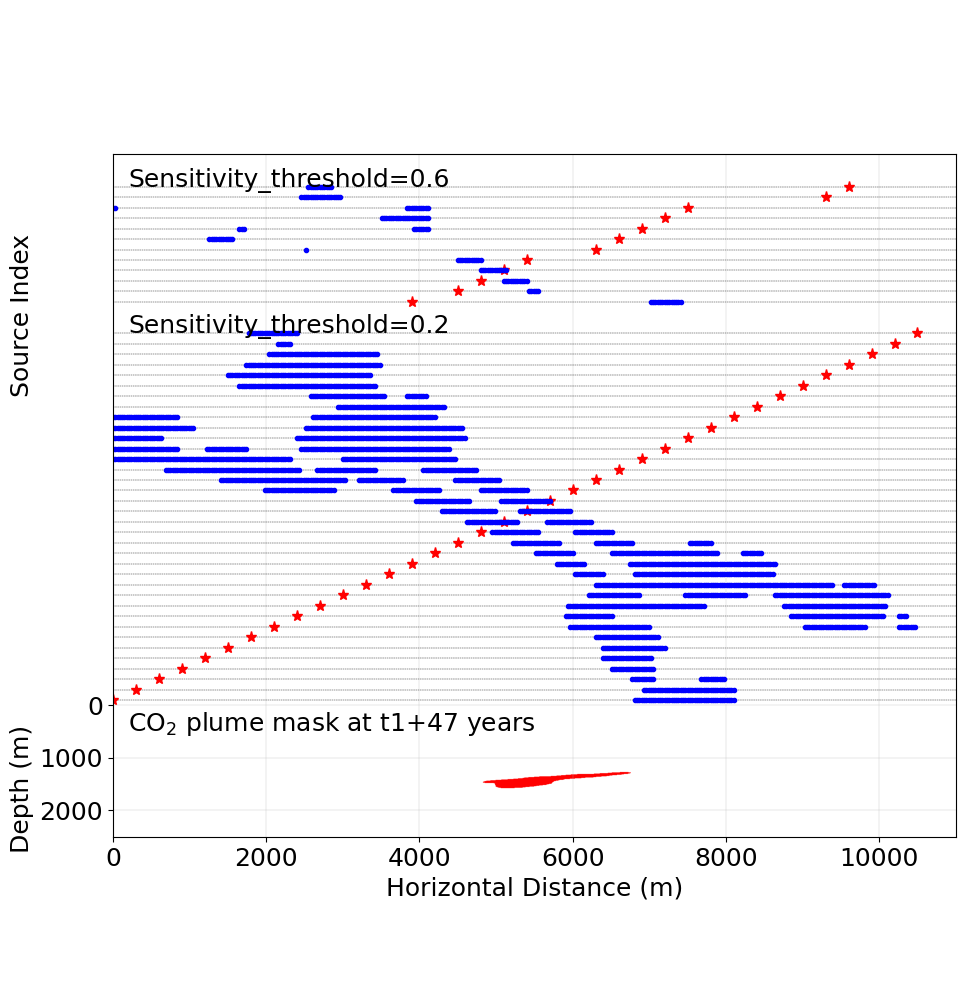

In [19]:
# Plot the optimal seismic survey design (sources and receivers) at six time points
# Each plot shows a CO2 plume at the bottom and two seismic survey designs 
# cooresponding to two sensitivity thresholds
k = 0
num_source_max = np.array([0,0], dtype=np.int32)
for wf in wavefield[:1]:
    for ps in VpVs[:1]:
        # assume max number of sources occurs at the last time point
        sens2d = load_sensitivity_data(timestamps[-1], wf, ps)
        design = find_optimal_seismic_arrays(sens2d,sensitivity_threshold[0])
        num_source_max[0], _ = find_optimal_sources(design)
        design = find_optimal_seismic_arrays(sens2d,sensitivity_threshold[1])
        num_source_max[1], _ = find_optimal_sources(design)

        for i, yr in enumerate(timestamps):
            sens2d = load_sensitivity_data(yr, wf, ps)
            design1 = find_optimal_seismic_arrays(sens2d,sensitivity_threshold[0])
            design2 = find_optimal_seismic_arrays(sens2d,sensitivity_threshold[1])
            plot_optimal_design(design1,design2,wf,ps,yr,num_source_max)
        k += 1